# `017` Hyperparameter tuning

Requirements: 005 Multilayer perceptron.

☢️☢️☢️WORK IN PROGRESS☢️☢️☢️

When training a neural network, we define a function with several parameters, and the optimizer tries to adjust them correctly. But there are a few more knobs that we can twist that could also be considered parameters, but are not learnt by the....


There are a few parameters that can be passed to the model initialization and training code. In machine learning, the parameters that the model tries to learn during training are called, indeed, parameters. However, these other parameters that define how the model is shaped and trained are called hyperparameters.

Unfortunately, neural networks are very sensitive to the configuration of these hyperparameters. Most modern architectures provide layers that focus on adding reducing hyperparameter dependency, but still it's important to understand how to adjust them.

For this, we're using a clean version of the code from the MLP notebook.

In [68]:
from math import pi
import torch

f = lambda x: torch.atan(x**3 - 2 * x + 3) - 5

def get_dataset(f=f, x_range=(-pi * 2, pi * 2, 0.01), train_ratio=0.8):
	X = torch.arange(*x_range)
	X = X.view(-1, 1)
	Y = f(X)
	Y = (Y - Y.mean()) / Y.std()
	if train_ratio is None: return X, Y
	ix = torch.randperm(X.size(0))
	X, Y = X[ix], Y[ix]
	test_cut = int(X.size(0) * train_ratio)
	Xtr, Ytr = X[:test_cut], Y[:test_cut]
	Xts, Yts = X[test_cut:], Y[test_cut:]
	return Xtr, Ytr, Xts, Yts

def get_model(hidden_size=100):
	W1 = torch.randn(1, hidden_size)
	b1 = torch.zeros(hidden_size)
	W2 = torch.randn(hidden_size, hidden_size) / hidden_size**.5
	b2 = torch.zeros(hidden_size)
	W3 = torch.randn(hidden_size, 1) / hidden_size**.5
	b3 = torch.zeros(1)
	parameters = W1, b1, W2, b2, W3, b3
	for p in parameters: p.requires_grad = True
	return parameters

def forward(model, x):
	W1, b1, W2, b2, W3, b3 = model
	out = x @ W1 + b1
	out = out.relu()
	out = out @ W2 + b2
	out = out.relu()
	out = out @ W3 + b3
	return out

def train(model, X, Y, step_size=0.001, iterations=100):
	losses = []
	for _ in range(iterations):
		Ypred = forward(model, X)
		loss = ((Ypred - Y)**2).mean()
		for p in model: p.grad = None
		loss.backward()
		for p in model: p.data -= p.grad * step_size
		losses.append(loss.item())
	return losses

### Learning rate

 Let's start by testing a few different values for the learning rate or step size.

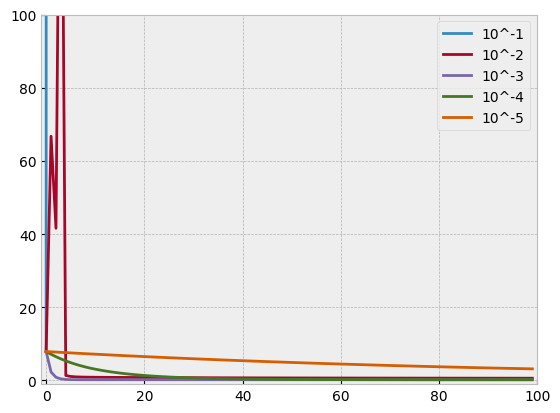

In [69]:

from matplotlib import pyplot as plt
import torch

X, Y = get_dataset(train_ratio=None)
for exp in range(1, 6):
	torch.manual_seed(1234)  # for reproducibility
	plt.plot(train(get_model(), X, Y, step_size=10**-exp), label=f'10^-{exp}')
plt.xlim((-1, 100))  # look just at the first 100 iterations
plt.ylim((-1, 100))  # look just at the first 100 iterations
plt.legend();

A few observations are that:
* $10^{-3}$ makes it converge pretty fast towards the optimum.
* $10^{-2}$ and smaller is too big and the gradients become extremely large within very few iterations. This is the problem of exploding gradients, that is always present when stacking multiple layers and can be solved in a few different ways.
* $10^{-4}$ and $10^{-5}$ are too small and even though eventually will converge, they take too many steps.

Adjusting the learning rate can make a huge difference in the training process. Although modern networks and optimizers have figured out how to deal with this problem, it's still important to understand how to adjust it. A common practice is to start with a very small learning rate and duplicate it until the loss starts to oscillate.

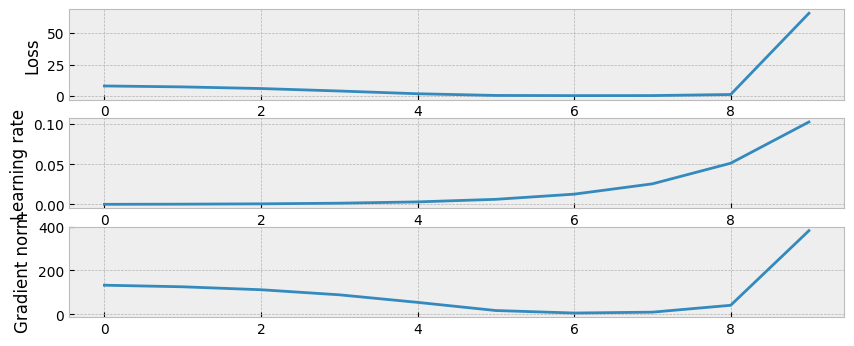

In [70]:
torch.manual_seed(1234)
model = get_model()
step_size = 0.0001
losses = []
step_sizes = []
norms = []
for i in range(10):
	Ypred = forward(model, X)
	loss = ((Ypred - Y)**2).mean()
	for p in model: p.grad = None
	loss.backward()
	norms.append(sum(p.grad.norm() for p in model))
	for p in model: p.data -= p.grad * step_size
	step_size = step_size * 2
	losses.append(loss.item())
	step_sizes.append(step_size)

plt.figure(figsize=(10, 4))
plt.subplot(311)
plt.plot(losses)
plt.ylabel('Loss')
plt.subplot(312)
plt.plot(step_sizes)
plt.ylabel('Learning rate')
plt.subplot(313)
plt.plot(norms)
plt.ylabel('Gradient norm');

In the previous example, a loss of $0.05$ was already too much to make the network converge. We can observe them in two different ways: (a) the loss starts oscillating or exploding, and (b) the gradients become too large or too small. The latter can be observed by printing the gradient norm, which is the norm of the gradient vector. If it's too large, the network will not converge.

### Number of iterations

This parameter is closely tied to the learning rate. If the learning rate is too small, the number of iterations will be too high. If the learning rate is too high, the number of iterations will be too low. The number of iterations is also called the number of epochs.

There is also another consideration about having too many iterations, which is the overfitting. When the network is trained for too many iterations, it starts to memorize the training data instead of learning the patterns. There are a few ways to solve this problem, and one of them is early stopping, which is just stopping the training when the test set loss starts to increase. It's unlikely that this happens with our super simple model, so let's try something a bit more complicated.

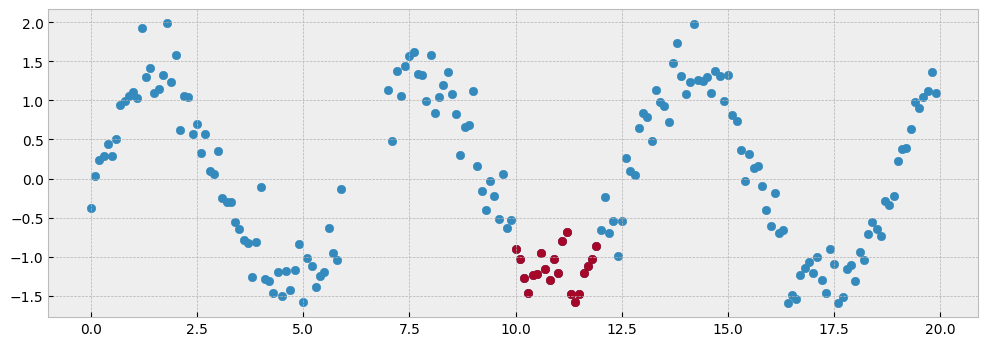

In [88]:
f = lambda x: torch.sin(x) + torch.randn_like(x) * 0.2
X, Y = get_dataset(f, x_range=(0, 20, .1), train_ratio=None)
Xts, Yts = X[100:120], Y[100:120]
Xtr, Ytr = torch.cat([X[:60], X[70:]]), torch.cat([Y[:60], Y[70:]])
plt.figure(figsize=(12, 4))
plt.scatter(Xtr, Ytr);
plt.scatter(Xts, Yts);

By hiding important features of the curve in the train set, we can make more challenging for the network to be able to generalize.

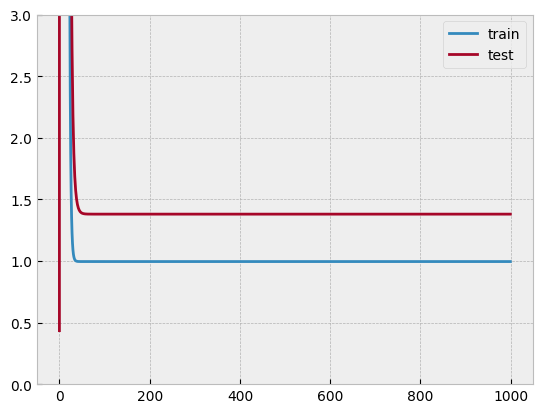

In [89]:
torch.manual_seed(1234)
model = get_model(hidden_size=50)

losses = []
test_losses = []
for _ in range(1000):
	Ypred = forward(model, X)
	loss = ((Ypred - Y)**2).mean()
	with torch.no_grad():  # this disables the gradient computation to avoid unnecesary overhead
		test_loss = ((forward(model, Xts) - Yts)**2).mean()
	for p in model: p.grad = None
	loss.backward()
	for p in model: p.data -= p.grad * .1
	losses.append(loss.item())
	test_losses.append(test_loss.item())

plt.plot(losses, label='train')
plt.plot(test_losses, label='test')
plt.ylim((0, 3))
plt.legend();

You can see how, by using a function that contain noise, the network starts overoptimizing for noise. Then, the final iterations seem like they're improving based on the train loss curve, but when looking at the test curve it's clear that the model is overfitting. Overfitting is a common problem in machine learning, that many different techniques have been developed to solve.

### Model size

The model size is the total number of learnable parameters in the model. The more simple your network is, the less capabilities it will have (intelligence is correlated with brain size, right?). However, the more complex it is, the more it will take to train and the more data it will need to generalize instead of memorize. Also, with the increase of the model size, the resources required to run the model will increase.

Same as with the learning rate, it is a good idea to start small and do tests with different sizes.

In [32]:
from time import time

X, Y = get_dataset(train_ratio=None)

for size in (100, 200, 500, 1000, 2000, 5000):
	torch.manual_seed(1234)
	model = get_model(hidden_size=size, scaling_factor=.1)
	start = time()
	loss = train(model, X, Y, step_size=0.001, iterations=100)[-1]
	print(f'{size:4} units took {time() - start:.2f}s to train and had a loss={loss:.4f}')

 100 units took 0.14s to train and had a loss=0.5147
 200 units took 0.18s to train and had a loss=0.1927
 500 units took 0.47s to train and had a loss=0.1711
1000 units took 1.06s to train and had a loss=0.1386
2000 units took 2.73s to train and had a loss=0.1413
5000 units took 15.02s to train and had a loss=nan
